##  Modeling the Impact of Lateral Flow Parameterizations on Basin Wide Runoff in the Reynolds Mountain East catchment using pySUMMA

## 1. Introduction

One part of the Clark et al. (2015) study explored the impact of the lateral flux of liquid water on total evapotranspiration (ET) using a SUMMA model for the Reynolds Mountain East catchment. This study looked at the sensitivity of the different model representation of the lateral flux of liquid water, which determines the availability of soil water.

In this Jupyter Notebook, the pySUMMA library is used to reproduce this analysis. First, the latertal flux from the soil profile is described. Next, the Methods section describes how the pySUMMA can be used to create three different lateral model representation of the Reynolds Mountain East catchment model, 1d Richards', lumped topmodel, and distributed topmodel. The Results section shows how to use pySUMMA and the Pandas library to reproduce Figure 8(right) from Clark et al. (2015).

Collectively, this Jupyter Notebook serves as an example of how hydrologic modeling can be conducted directly within a Jupyter Notebook by leveraging the pySUMMA library. 

 |                    Method                   | 1dRichards' |   Lumped Topmodel |   Distributed Topmodel |
 |---------------------------------------------|-------------|-------------------|------------------------|
 |         groundwater parameterization        | noXplict    | qTopmodl          | qTopmodl               |
 |       hydraulic conductivity profile        | constant    | pow_prof          | pow_prof               |
 |lower boundary condition for soil hydrology  | drainage    | zeroFlux          | zeroFlux               |
 |thermal conductivity representation for soil | mixConstit  | funcSoilWet       | funcSoilWet            |

## 2. Background

### The Transpiration from soil layers available in SUMMA

In [159]:
#import libraries to display equations within the notebook
from IPython.display import display, Math, Latex

### Latertal flux from the soil profile

The soil columns can be hydrologically connected, such that the lateral flux from upslope soil columns is the inflow to downslope soil columns, or hydrologically-disconnected (using one or many soil columns), in which case the lateral flux of water from soil columns is assumed to flow directly into the river network.

The continuity equation for sub-surface storage (i.e., below the water table) can be written for a given model element as [Wigmosta et al., 1994]

\begin{equation*}
Q_{dr} = \frac{dz_{wt}}{dt} = \frac{Q_{out}-Q_{in}}{A} - q_{rchg}
\end{equation*}

$Q_{dr} = (\theta_{sat}^{soil} - \theta_{fc}^{soil}) $ : “drainable” porosity, $\theta_{fc}^{soil}$ : the field capacity of soil, $z_{wt}$ $(m)$ : the depth to the water table

$Q_{out}$ and $Q_{in}$ $(m^{3}/s)$: the lateral inflow and outflow, $q_{rchg}$ $(m/s)$ : the vertical recharge rate, $A$ $(m^2)$ : the element area

#### Storage-based implementation to represent lateral flow between soil columns

The “drainable” water storage and the maximum drainable water storage can be given as
\begin{equation*}
W_{dr}^{soil} = \int_{z_{crit}}^{z_{soil}}\ [\theta_{liq}^{soil} (z) - \theta_{fc}^{soil} ] \mathrm{d}z, \          W_{dr,max}^{soil} = \phi_{dr}z_{soil}
\end{equation*}

$\theta_{liq}^{soil} (z)$ : the volumetric liquid water content at soil depth z, $z_{crit}$ : the lowest point in the soil profile where $\theta_{liq}^{soil}$ < $\theta_{fc}^{soil}$

#### The total lateral outflow

\begin{equation*}
Q_{out} = x_{len}tan(\beta) \frac{K_{sat}^{0} W_{dr,max}^{soil}}{\phi_{dr}n_{sf}}[\frac{W_{dr}^{soil}}{W_{dr,max}^{soil}}]^{n_{sf}}
\end{equation*}

$\beta$ : the gradient in the land surface, used to approximate the water table gradient

#### The total lateral flux

\begin{equation*}
q_{base}^{soil} =  \frac{Q_{out}-Q_{in}}{A}
\end{equation*}

The total lateral flux $q_{base}^{soil}$ can then be apportioned to individual soil layers, obtained after spatial discretization described in Clark et al. [2015b], to provide the lateral flow sink term

\begin{equation*}
(S_{lf})_{j} = (w_{tv})_{j}   q_{base}^{soil}
\end{equation*}

$(w_{tv})_{j}$ : the ratio of the transmissivity of the $j$-th layer to the total transmissivity

The above descriptions are taken from the lateral flux from the soil profile section(3.2.3.5) within the manual Structure for Unifying Multiple Modeling Alternatives (SUMMA), Version 1.0: Technical Description (April, 2015).

## 3. Methods

### 1) Study Area

#### The Reynolds Mountain East catchment is located in southwestern Idaho as shown in the figure below.

In [1]:
from ipyleaflet import Map, GeoJSON
import json

In [2]:
m = Map(center=[43.06745, -116.75489], zoom=15)
with open('reynolds_geojson_latlon.geojson') as f:
    data = json.load(f)
g = GeoJSON(data=data)
m.add_layer(g)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[43.06745, -116.75489], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']), GeoJSON(data={'type': 'FeatureCollection', 'name': 'reynolds_geojson_latlon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}, 'features': [{'type': 'Feature', 'properties': {'OBJECTID': 1, 'RCEW_REGIO': 376208.194027, 'PERIMETER': 3340.0, 'RMEAST_MAS': 2, 'RMEAST_M_1': 2, 'GRID_CODE': 1}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-116.7557156288284, 43.07072983625339], [-116.75559279969227, 43.07072957489522], [-116.75559315872648, 43.07063952502811], [-116.75547032977175, 43.07063926353894], [-116.75534750204696, 43.07063900192053], [-116.75522467432737, 43.07063873926983], [-116.7551018453776, 43.07063847738518], [-116.75510220512943, 43.0705484275199], [-116.75497937636112, 43.07054816550426], [-116.75497973629112, 43.070458115638395], [-116.75485690770425, 43.07045785349174], [-116.7547340803473, 43.07045759121584], [-116.754611252992, 43.070457328808125], [-116.75448842441011, 43.07045706626597], [-116.75436559706174, 43.070456802694125], [-116.75424276848315, 43.07045653988829], [-116.75424312949033, 43.070366490025975], [-116.75412030232148, 43.070366227091775], [-116.75399747392602, 43.0703659640231], [-116.75399783529119, 43.07027591416101], [-116.75387500707716, 43.07027565096134], [-116.7537521800931, 43.07027538763253], [-116.75362935188241, 43.07027512416918], [-116.75362971378532, 43.07018507430818], [-116.75363007445833, 43.07009502444305], [-116.75363043635795, 43.07000497457918], [-116.75363079702761, 43.06991492471125], [-116.75375362451547, 43.06991518907176], [-116.75375398500368, 43.06982513920156], [-116.75375434671845, 43.06973508933261], [-116.75375470720336, 43.06964503945952], [-116.75363188147955, 43.06964477600465], [-116.7536322421426, 43.069554726130995], [-116.75350941660027, 43.06955446254514], [-116.75350977744145, 43.06946441267091], [-116.75338695208056, 43.06946414895402], [-116.75338731309988, 43.0693740990792], [-116.75326448792045, 43.06937383523132], [-116.75326485034614, 43.06928378535855], [-116.75314202411995, 43.06928352137701], [-116.75301919912368, 43.069283257266314], [-116.75301956067906, 43.06919320739113], [-116.753019923461, 43.06910315751716], [-116.75289709759774, 43.069102893273666], [-116.7527742729644, 43.06910262890097], [-116.75277463610426, 43.06901257902725], [-116.75265181042415, 43.069012314520926], [-116.75265217374212, 43.06892226464661], [-116.75252934824346, 43.06892200000929], [-116.75252971173958, 43.06883195013435], [-116.7525300740058, 43.0687419002554], [-116.75240725009662, 43.068741635490554], [-116.75240761254095, 43.06865158561097], [-116.75240797621186, 43.06856153573259], [-116.75240833865288, 43.06847148585014], [-116.7524087023168, 43.06838143686942], [-116.75228587790387, 43.06838117107297], [-116.75228624174592, 43.068291122091665], [-116.7522866043617, 43.068201072205795], [-116.75228696820399, 43.06811102232113], [-116.75228733081644, 43.06802097243243], [-116.75228769465541, 43.067930922544896], [-116.75228805726088, 43.067840873553784], [-116.75228842109648, 43.06775082366344], [-116.75216559794013, 43.06775055864152], [-116.75216596195388, 43.06766050875055], [-116.75204313897898, 43.06766024359765], [-116.75192031723756, 43.067659977415076], [-116.7517974954942, 43.067659712001166], [-116.75167467252432, 43.06765944645277], [-116.75167503725551, 43.06756939656374], [-116.75167540075684, 43.067479346670616], [-116.75167576548104, 43.067389297679235], [-116.75167612897903, 43.06729924778324], [-116.75155330795809, 43.067298982109065], [-116.75155367163417, 43.06720893221254], [-116.75155403653679, 43.06711888231719], [-116.7515544002095, 43.06702883241775

### 2) Download TestCases from HS and Installation to prepare SUMMA simulation

In [3]:
# To authenticate using HTTP Basic authentication.
from hs_restclient import HydroShare, HydroShareAuthBasic

In [4]:
# import utils.py to download TestCases from HS, unzip and installation
from pysumma.utils import utils

In [5]:
# define directory where you save SUMMA TestCases
save_filepath = '/media/sf_pysumma'

In [ ]:
# call install_test_cases_hs method to download TestCase from HS, unzip and install the TestCase.
hs_path = utils.install_test_cases_hs(save_filepath)

In [6]:
# if you already have TestCase in your local, you can skip previous statement
hs_path = save_filepath+'/a0105d479c334764ba84633c5b9c1c01/a0105d479c334764ba84633c5b9c1c01/data/contents'

### 3) Create pySUMMA Simulation Object of 1d Richards method and Run SUMMA Model

In [7]:
from pysumma.Simulation import Simulation
from pysumma.Plotting import Plotting

In [8]:
# create a pySUMMA simulation object using the SUMMA 'file manager' input file 
S_1dRichards = Simulation(hs_path + '/summaTestCases_2.x/settings/wrrPaperTestCases/figure09/summa_fileManager_1dRichards.txt')

ModelOuput master file filepath: /media/sf_pysumma/pysumma/notebooks/var_lookup.f90


In [9]:
# set SUMMA executable file
excutable = '/media/sf_pysumma/a5dbd5b198c9468387f59f3fefc11e22/a5dbd5b198c9468387f59f3fefc11e22/data/contents/summa-master/bin'
S_1dRichards.executable = excutable +'/summa.exe'

In [10]:
# check the simulation start and finish times
S_1dRichards.decision_obj.simulStart.value, S_1dRichards.decision_obj.simulFinsh.value

('2002-07-01 00:00', '2008-09-30 00:00')

In [11]:
# check option and selected method of (11) choice of groundwater parameterization in Decision file
S_1dRichards.decision_obj.groundwatr.options, S_1dRichards.decision_obj.groundwatr.value

(['qTopmodl', 'bigBuckt', 'noXplict'], 'noXplict')

In [12]:
# check option and selected method of (12) choice of hydraulic conductivity profile in Decision file
S_1dRichards.decision_obj.hc_profile.options, S_1dRichards.decision_obj.hc_profile.value

(['constant', 'pow_prof'], 'constant')

In [13]:
# check option and selected method of (16) type of lower boundary condition for soil hydrology in Decision file
S_1dRichards.decision_obj.bcLowrSoiH.options, S_1dRichards.decision_obj.bcLowrSoiH.value

(['drainage', 'presHead', 'bottmPsi', 'zeroFlux'], 'drainage')

In [14]:
# check option and selected method of (27) choice of thermal conductivity representation for soil in Decision file
S_1dRichards.decision_obj.thCondSoil.options, S_1dRichards.decision_obj.thCondSoil.value

(['funcSoilWet', 'mixConstit', 'hanssonVZJ'], 'mixConstit')

In [15]:
# check Basin variable meta data in file manager file
S_1dRichards.meta_basinvar.filename

'summa_zBasinModelVarMeta.txt'

In [16]:
# check Basin Parameter info data in file manager file
S_1dRichards.basin_par.filename

'summa_zBasinParamInfo.txt'

In [17]:
# check Forcing list data in file manager file
S_1dRichards.forcing_list.filename

'summa_zForcingFileList_riparianAspen_1dRichards.txt'

In [18]:
# check Initial condition data in file manager file
S_1dRichards.initial_cond.filename

'summa_zInitialCond.nc'

#### If you have an output file, you don't need to run SUMMA. Move next

In [19]:
# run the model giving the output the suffix "1dRichards_local" and get "results_1dRichards" object
results_1dRichards, output_R = S_1dRichards.execute(run_suffix="1dRichards_local", run_option = 'local')

file_suffix is '1dRichards_local'.
file_master is '/media/sf_pysumma/a0105d479c334764ba84633c5b9c1c01/a0105d479c334764ba84633c5b9c1c01/data/contents/summaTestCases_2.x/settings/wrrPaperTestCases/figure09/summa_fileManager_1dRichards.txt'.
start at 08:48:12
Name of Model Output control file: /media/sf_pysumma/a0105d479c334764ba84633c5b9c1c01/a0105d479c334764ba84633c5b9c1c01/data/contents/summaTestCases_2.x/settings/meta/Model_Output.txt
decisions file =  /media/sf_pysumma/a0105d479c334764ba84633c5b9c1c01/a0105d479c334764ba84633c5b9c1c01/data/contents/summaTestCases_2.x/settings/wrrPaperTestCases/figure09/summa_zDecisions_1dRichards.txt
   1 simulStart: 2002-07-01 00:00
   2 simulFinsh: 2008-09-30 00:00
   3 soilCatTbl: ROSETTA
   4 vegeParTbl: USGS
   5 soilStress: NoahType
   6 stomResist: BallBerry
   7 num_method: itertive
   8 fDerivMeth: analytic
   9 LAI_method: specified
  10 f_Richards: mixdform
  11 groundwatr: noXplict
  12 hc_profile: constant
  13 bcUpprTdyn: nrg_flux
  14 b

In [21]:
R = Plotting(output_R)
results_1dRichards = R.open_netcdf()

### 4) Create pySUMMA Simulation Object of Lumped Topmodel method and Run SUMMA Model

In [20]:
# create a pySUMMA simulation object using the SUMMA 'file manager' input file 
S_lumpedTopmodel = Simulation(hs_path + '/summaTestCases_2.x/settings/wrrPaperTestCases/figure09/summa_fileManager_lumpedTopmodel.txt')

ModelOuput master file filepath: /media/sf_pysumma/pysumma/notebooks/var_lookup.f90


In [21]:
# set SUMMA executable file
excutable = '/media/sf_pysumma/a5dbd5b198c9468387f59f3fefc11e22/a5dbd5b198c9468387f59f3fefc11e22/data/contents/summa-master/bin'
S_lumpedTopmodel.executable = excutable +'/summa.exe'

In [22]:
# check the simulation start and finish times
S_lumpedTopmodel.decision_obj.simulStart.value, S_lumpedTopmodel.decision_obj.simulFinsh.value

('2001-07-01 00:00', '2008-09-30 00:00')

In [23]:
# check option and selected method of (11) choice of groundwater parameterization in Decision file
S_lumpedTopmodel.decision_obj.groundwatr.options, S_lumpedTopmodel.decision_obj.groundwatr.value

(['qTopmodl', 'bigBuckt', 'noXplict'], 'qTopmodl')

In [24]:
# check option and selected method of (12) choice of hydraulic conductivity profile in Decision file
S_lumpedTopmodel.decision_obj.hc_profile.options, S_lumpedTopmodel.decision_obj.hc_profile.value

(['constant', 'pow_prof'], 'pow_prof')

In [25]:
# check option and selected method of (16) type of lower boundary condition for soil hydrology in Decision file
S_lumpedTopmodel.decision_obj.bcLowrSoiH.options, S_lumpedTopmodel.decision_obj.bcLowrSoiH.value

(['drainage', 'presHead', 'bottmPsi', 'zeroFlux'], 'zeroFlux')

In [26]:
# check option and selected method of (27) choice of thermal conductivity representation for soil in Decision file
S_lumpedTopmodel.decision_obj.thCondSoil.options, S_lumpedTopmodel.decision_obj.thCondSoil.value

(['funcSoilWet', 'mixConstit', 'hanssonVZJ'], 'funcSoilWet')

In [27]:
# check Basin variable meta data in file manager file
S_lumpedTopmodel.meta_basinvar.filename

'summa_zBasinModelVarMeta.txt'

In [28]:
# check Basin Parameter info data in file manager file
S_lumpedTopmodel.basin_par.filename

'summa_zBasinParamInfo.txt'

In [29]:
# check Forcing list data in file manager file
S_lumpedTopmodel.forcing_list.filename

'summa_zForcingFileList_riparianAspen_lumpedTopmodel.txt'

In [30]:
# check Initial condition data in file manager file
S_lumpedTopmodel.initial_cond.filename

'summa_zInitialCond.nc'

#### If you have an output file, you don't need to run SUMMA. Move next

In [31]:
# run the model giving the output the suffix "lumpedTopmodel_local" and get "results_lumpedTopmodel" object
results_lumpedTopmodel, output_LT = S_lumpedTopmodel.execute(run_suffix="lumpedTopmodel_local", run_option = 'local')

file_suffix is 'lumpedTopmodel_local'.
file_master is '/media/sf_pysumma/a0105d479c334764ba84633c5b9c1c01/a0105d479c334764ba84633c5b9c1c01/data/contents/summaTestCases_2.x/settings/wrrPaperTestCases/figure09/summa_fileManager_lumpedTopmodel.txt'.
start at 08:49:24
Name of Model Output control file: /media/sf_pysumma/a0105d479c334764ba84633c5b9c1c01/a0105d479c334764ba84633c5b9c1c01/data/contents/summaTestCases_2.x/settings/meta/Model_Output.txt
decisions file =  /media/sf_pysumma/a0105d479c334764ba84633c5b9c1c01/a0105d479c334764ba84633c5b9c1c01/data/contents/summaTestCases_2.x/settings/wrrPaperTestCases/figure09/summa_zDecisions_lumpedTopmodel.txt
   1 simulStart: 2001-07-01 00:00
   2 simulFinsh: 2008-09-30 00:00
   3 soilCatTbl: ROSETTA
   4 vegeParTbl: USGS
   5 soilStress: NoahType
   6 stomResist: BallBerry
   7 num_method: itertive
   8 fDerivMeth: analytic
   9 LAI_method: specified
  10 f_Richards: mixdform
  11 groundwatr: qTopmodl
  12 hc_profile: pow_prof
  13 bcUpprTdyn: nrg

In [34]:
L = Plotting(output_LT)
results_lumpedTopmodel = L.open_netcdf()

### 5) Create pySUMMA Simulation Object of Distributed Topmodel method and Run SUMMA Model

In [32]:
# create a pySUMMA simulation object using the SUMMA 'file manager' input file 
S_distributedTopmodel = Simulation(hs_path + '/summaTestCases_2.x/settings/wrrPaperTestCases/figure09/summa_fileManager_distributedTopmodel.txt')

ModelOuput master file filepath: /media/sf_pysumma/pysumma/notebooks/var_lookup.f90


In [33]:
# set SUMMA executable file
excutable = '/media/sf_pysumma/a5dbd5b198c9468387f59f3fefc11e22/a5dbd5b198c9468387f59f3fefc11e22/data/contents/summa-master/bin'
S_distributedTopmodel.executable = excutable +'/summa.exe'

In [34]:
# check the simulation start and finish times
S_distributedTopmodel.decision_obj.simulStart.value, S_distributedTopmodel.decision_obj.simulFinsh.value

('2001-07-01 00:00', '2008-09-30 00:00')

In [35]:
# check option and selected method of (11) choice of groundwater parameterization in Decision file
S_distributedTopmodel.decision_obj.groundwatr.options, S_distributedTopmodel.decision_obj.groundwatr.value

(['qTopmodl', 'bigBuckt', 'noXplict'], 'qTopmodl')

In [36]:
# check option and selected method of (12) choice of hydraulic conductivity profile in Decision file
S_distributedTopmodel.decision_obj.hc_profile.options, S_distributedTopmodel.decision_obj.hc_profile.value

(['constant', 'pow_prof'], 'pow_prof')

In [37]:
# check option and selected method of (16) type of lower boundary condition for soil hydrology in Decision file
S_distributedTopmodel.decision_obj.bcLowrSoiH.options, S_distributedTopmodel.decision_obj.bcLowrSoiH.value

(['drainage', 'presHead', 'bottmPsi', 'zeroFlux'], 'zeroFlux')

In [38]:
# check option and selected method of (27) choice of thermal conductivity representation for soil in Decision file
S_distributedTopmodel.decision_obj.thCondSoil.options, S_distributedTopmodel.decision_obj.thCondSoil.value

(['funcSoilWet', 'mixConstit', 'hanssonVZJ'], 'funcSoilWet')

In [39]:
# check Basin variable meta data in file manager file
S_distributedTopmodel.meta_basinvar.filename

'summa_zBasinModelVarMeta.txt'

In [40]:
# check Basin Parameter info data in file manager file
S_distributedTopmodel.basin_par.filename

'summa_zBasinParamInfo.txt'

In [41]:
# check Forcing list data in file manager file
S_distributedTopmodel.forcing_list.filename

'summa_zForcingFileList_fullDist.txt'

In [42]:
# check Initial condition data in file manager file
S_distributedTopmodel.initial_cond.filename

'summa_zInitialCond_disTop.nc'

#### If you have output an file, you don't need to run SUMMA. Move next

In [43]:
# run the model giving the output the suffix "distributedTopmodel_docker_develop" and get "results_distributedTopmodel" object
results_distributedTopmodel, output_DT = S_distributedTopmodel.execute(run_suffix="distributedTopmodel_local", run_option = 'local')

file_suffix is 'distributedTopmodel_local'.
file_master is '/media/sf_pysumma/a0105d479c334764ba84633c5b9c1c01/a0105d479c334764ba84633c5b9c1c01/data/contents/summaTestCases_2.x/settings/wrrPaperTestCases/figure09/summa_fileManager_distributedTopmodel.txt'.
start at 08:50:40
Name of Model Output control file: /media/sf_pysumma/a0105d479c334764ba84633c5b9c1c01/a0105d479c334764ba84633c5b9c1c01/data/contents/summaTestCases_2.x/settings/meta/Model_Output.txt
decisions file =  /media/sf_pysumma/a0105d479c334764ba84633c5b9c1c01/a0105d479c334764ba84633c5b9c1c01/data/contents/summaTestCases_2.x/settings/wrrPaperTestCases/figure09/summa_zDecisions_distributedTopmodel.txt
   1 simulStart: 2001-07-01 00:00
   2 simulFinsh: 2008-09-30 00:00
   3 soilCatTbl: ROSETTA
   4 vegeParTbl: USGS
   5 soilStress: NoahType
   6 stomResist: BallBerry
   7 num_method: itertive
   8 fDerivMeth: analytic
   9 LAI_method: specified
  10 f_Richards: mixdform
  11 groundwatr: qTopmodl
  12 hc_profile: pow_prof
  13 

In [47]:
D = Plotting(output_DT)
results_distributedTopmodel = D.open_netcdf()

## 4. Results

### Recreate the Figure 9 plot from Clark et al., 2015: The Basin-Wide Runoff for the model representation of the lateral flux of liquid water

In [44]:
from pysumma.Plotting import Plotting
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import pandas as pd

#### 4.1) Create function to calculate daily runoff from SUMMA output for the period 1 oct 2002 to 1 oct 2008

In [45]:
def calc_total_runoff(runoff_output_df):
    # average Instance Runoff variable is runoff
    runoff = runoff_output_df['averageInstantRunoff']
    dates = runoff.coords['time'].data
    # create data value(Y-axis) attribute from ouput netcdf
    data_values = runoff.data*86400000
    # create two dimensional tabular data structure 
    total_runoff_df = pd.DataFrame(data_values, index=dates)
    # round time to nearest hour (ex. 2006-10-01T00:59:59.99 -> 2006-10-01T01:00:00)
    total_runoff_df.index = total_runoff_df.index.round("D")
    # set the time period to display plot 
    total_runoff_df = total_runoff_df.loc["2002-10-01":"2008-09-30"]
    # resample data by the average value hourly
    total_runoff_by_daily = total_runoff_df.resample("D").mean()
    return total_runoff_by_daily

#### 4.2) Get daily runoff

In [46]:
# get daily runoff output using 1d Richards method(1d Richards method appied 1 hru)
daily_1dRichards = calc_total_runoff(results_1dRichards)
# get daily runoff output using lumped Topmodel method (lumped Topmodel method appied 1 hru)
daily_lumpedTopmodel = calc_total_runoff(results_lumpedTopmodel)
# get daily runoff output using distributed Topmodel method (distributed Topmodel method appied 1 hru)
daily_distributedTopmodel = calc_total_runoff(results_distributedTopmodel)

#### 4.3) Combine the different lateral flux parameterizations on simulations of runoff into a single Pandas Dataframe

In [47]:
# Combine the different lateral flux parameterizations on simulations of runoff
Runoff_Combine = pd.concat([daily_1dRichards, daily_lumpedTopmodel, daily_distributedTopmodel], axis=1)
# add label 
Runoff_Combine.columns = ["Baseflow = 1D Richards'", 'Baseflow = Topmodel(lumped)', 'Baseflow = Topmodel(distributed)']

In [48]:
Runoff_Combine.head()

,Baseflow = 1D Richards',Baseflow = Topmodel(lumped),Baseflow = Topmodel(distributed)
2002-10-01,0.000072,0.000003,0.000112
2002-10-02,0.000072,0.000003,0.000112
2002-10-03,0.000072,0.000003,0.000111
2002-10-04,0.000072,0.000003,0.000110
2002-10-05,0.000072,0.000003,0.000110


#### 4.4) Add obervation data from streamflow station and Reynolds Mountain East to the plot

In [49]:
# create pySUMMA Plotting Object
Val_Streamflow = Plotting(hs_path + '/summaTestCases_2.x/testCases_data/validationData/ReynoldsCreek_valData.nc')

In [50]:
# read Runoff data(Q) from validation netcdf file
obs_streamflow = Val_Streamflow.ds['Q']
# create dates(X-axis) attribute from validation netcdf file
dates = obs_streamflow.coords['time'].data
# Change unit from cm/hr to mm/day
data_values = obs_streamflow.data*24*10
# create two dimensional tabular data structure 
df = pd.DataFrame(data_values, index=dates)
# set the time period to display plot
df_filt = df.loc["2002-10-01":"2008-09-30"]
# select label
df_filt.columns = ['Observations']
# resample data by the average daily from hourly 
obs_streamflow_daily = df_filt.resample("D").mean()
# set x index accoording to the change of time step
obs_date = obs_streamflow_daily.index

#### 4.5) Plotting output of the Parameterization of the Lateral Flux of Liquid Water and observation data

In [51]:
graph_runoff = pd.concat([Runoff_Combine, obs_streamflow_daily], 1)

In [62]:
graph_runoff.head()

,Baseflow = 1D Richards',Baseflow = Topmodel(lumped),Baseflow = Topmodel(distributed),Observations
2002-10-01,0.000072,0.000003,0.000112,0.06957
2002-10-02,0.000072,0.000003,0.000112,0.06950
2002-10-03,0.000072,0.000003,0.000111,0.07983
2002-10-04,0.000072,0.000003,0.000110,0.09851
2002-10-05,0.000072,0.000003,0.000110,0.08417


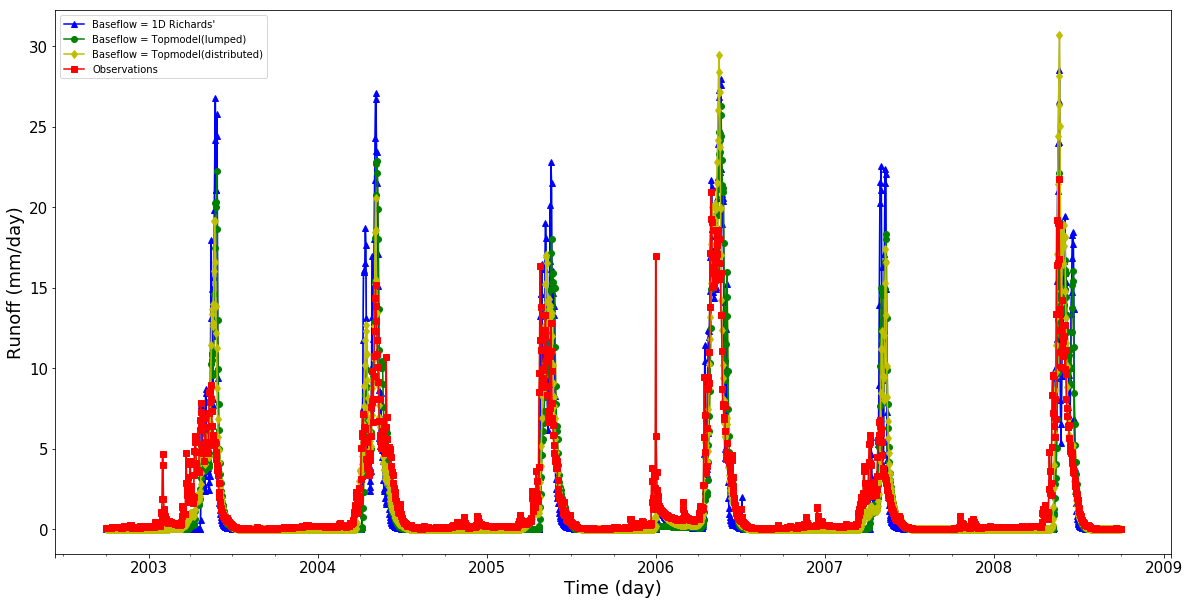

In [88]:
runoff_graph = graph_runoff.plot()

graph_runoff["Baseflow = 1D Richards'"].plot(color='b', marker='^') 
graph_runoff["Baseflow = Topmodel(lumped)"].plot(color='g', marker='o') 
graph_runoff["Baseflow = Topmodel(distributed)"].plot(color='y', marker='d') 
graph_runoff["Observations"].plot(color='r', marker='s') 

runoff_graph.tick_params(labelsize = 15)

runoff_graph.set_xlabel("Time (day)", fontsize=18)
runoff_graph.set_ylabel("Runoff (mm/day)", fontsize=18)

handles, labels = runoff_graph.get_legend_handles_labels()
runoff_graph.legend(handles[4:8], labels[4:8])

jtplot.figsize(x=20, y=10)

#### 4.6) Plotting output of the Parameterization of the Lateral Flux of Liquid Water and observation data for a year

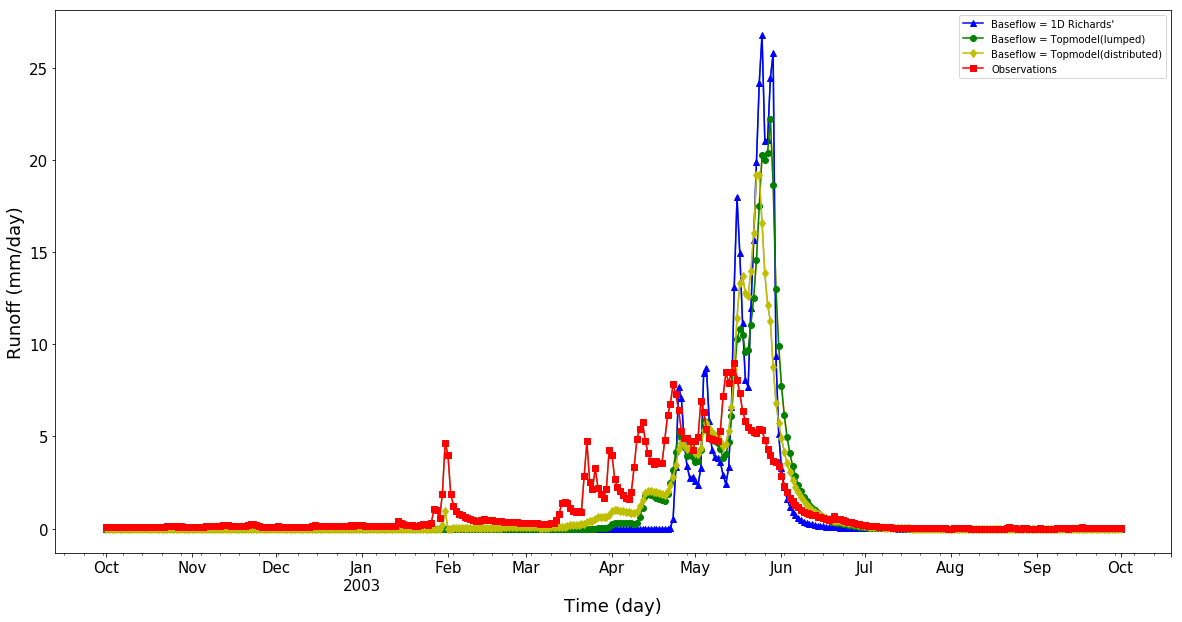

In [89]:
df_filt = df.loc["2002-10-01":"2003-10-01"]   
# select label
df_filt.columns = ['Observations']
# resample data by the average daily from hourly 
obs_streamflow_daily1 = df_filt.resample("D").mean()
# set x index accoording to the change of time step
obs_date = obs_streamflow_daily1.index
graph_runoff = pd.concat([Runoff_Combine.loc["2002-10-01":"2003-10-01"], obs_streamflow_daily1], 1)

runoff_graph = graph_runoff.plot()

graph_runoff["Baseflow = 1D Richards'"].plot(color='b', marker='^') 
graph_runoff["Baseflow = Topmodel(lumped)"].plot(color='g', marker='o') 
graph_runoff["Baseflow = Topmodel(distributed)"].plot(color='y', marker='d') 
graph_runoff["Observations"].plot(color='r', marker='s') 

runoff_graph.tick_params(labelsize = 15)

runoff_graph.set_xlabel("Time (day)", fontsize=18)
runoff_graph.set_ylabel("Runoff (mm/day)", fontsize=18)

handles, labels = runoff_graph.get_legend_handles_labels()
runoff_graph.legend(handles[4:8], labels[4:8])

jtplot.figsize(x=20, y=10)

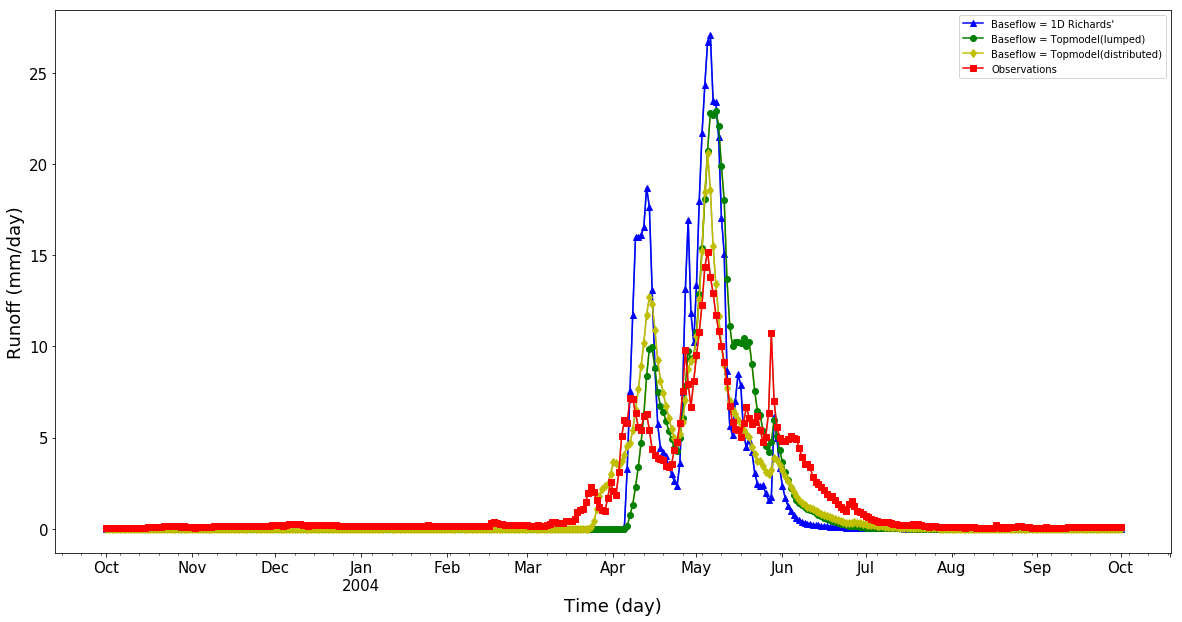

In [90]:
df_filt = df.loc["2003-10-01":"2004-10-01"]
# select label
df_filt.columns = ['Observations']
# resample data by the average daily from hourly 
obs_streamflow_daily1 = df_filt.resample("D").mean()
# set x index accoording to the change of time step
obs_date = obs_streamflow_daily1.index
graph_runoff = pd.concat([Runoff_Combine.loc["2003-10-01":"2004-10-01"], obs_streamflow_daily1], 1)

runoff_graph = graph_runoff.plot()

graph_runoff["Baseflow = 1D Richards'"].plot(color='b', marker='^') 
graph_runoff["Baseflow = Topmodel(lumped)"].plot(color='g', marker='o') 
graph_runoff["Baseflow = Topmodel(distributed)"].plot(color='y', marker='d') 
graph_runoff["Observations"].plot(color='r', marker='s') 

runoff_graph.tick_params(labelsize = 15)

runoff_graph.set_xlabel("Time (day)", fontsize=18)
runoff_graph.set_ylabel("Runoff (mm/day)", fontsize=18)

handles, labels = runoff_graph.get_legend_handles_labels()
runoff_graph.legend(handles[4:8], labels[4:8])

jtplot.figsize(x=20, y=10)

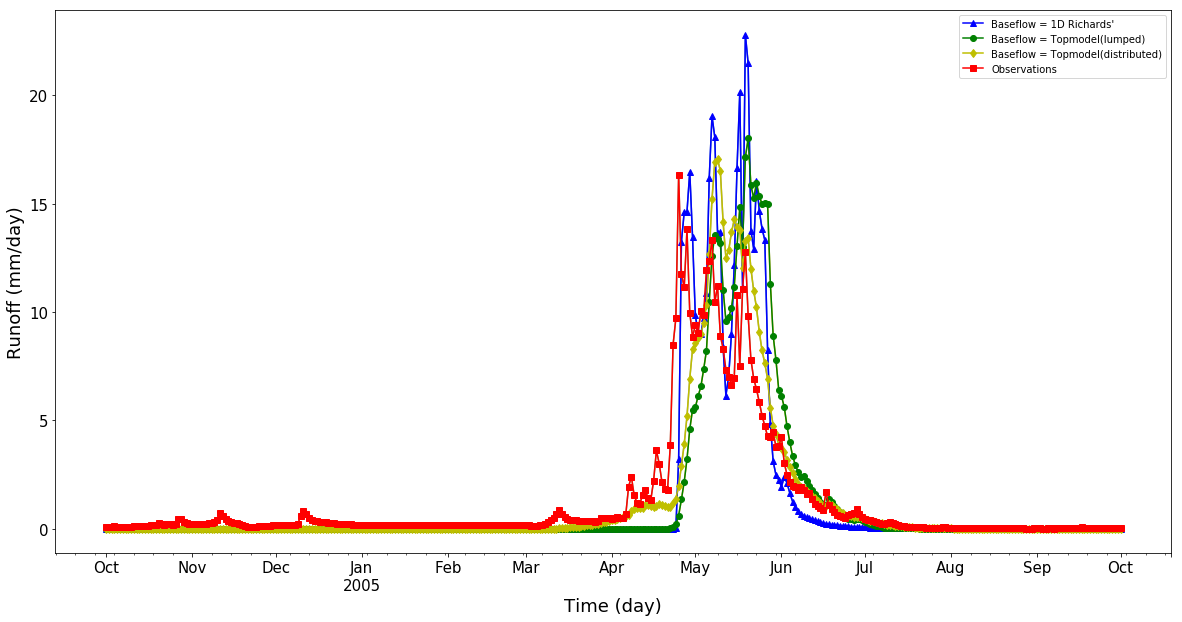

In [91]:
df_filt = df.loc["2004-10-01":"2005-10-01"]
# select label
df_filt.columns = ['Observations']
# resample data by the average daily from hourly 
obs_streamflow_daily1 = df_filt.resample("D").mean()
# set x index accoording to the change of time step
obs_date = obs_streamflow_daily1.index
graph_runoff = pd.concat([Runoff_Combine.loc["2004-10-01":"2005-10-01"], obs_streamflow_daily1], 1)

runoff_graph = graph_runoff.plot()

graph_runoff["Baseflow = 1D Richards'"].plot(color='b', marker='^') 
graph_runoff["Baseflow = Topmodel(lumped)"].plot(color='g', marker='o') 
graph_runoff["Baseflow = Topmodel(distributed)"].plot(color='y', marker='d') 
graph_runoff["Observations"].plot(color='r', marker='s') 

runoff_graph.tick_params(labelsize = 15)

runoff_graph.set_xlabel("Time (day)", fontsize=18)
runoff_graph.set_ylabel("Runoff (mm/day)", fontsize=18)

handles, labels = runoff_graph.get_legend_handles_labels()
runoff_graph.legend(handles[4:8], labels[4:8])

jtplot.figsize(x=20, y=10)

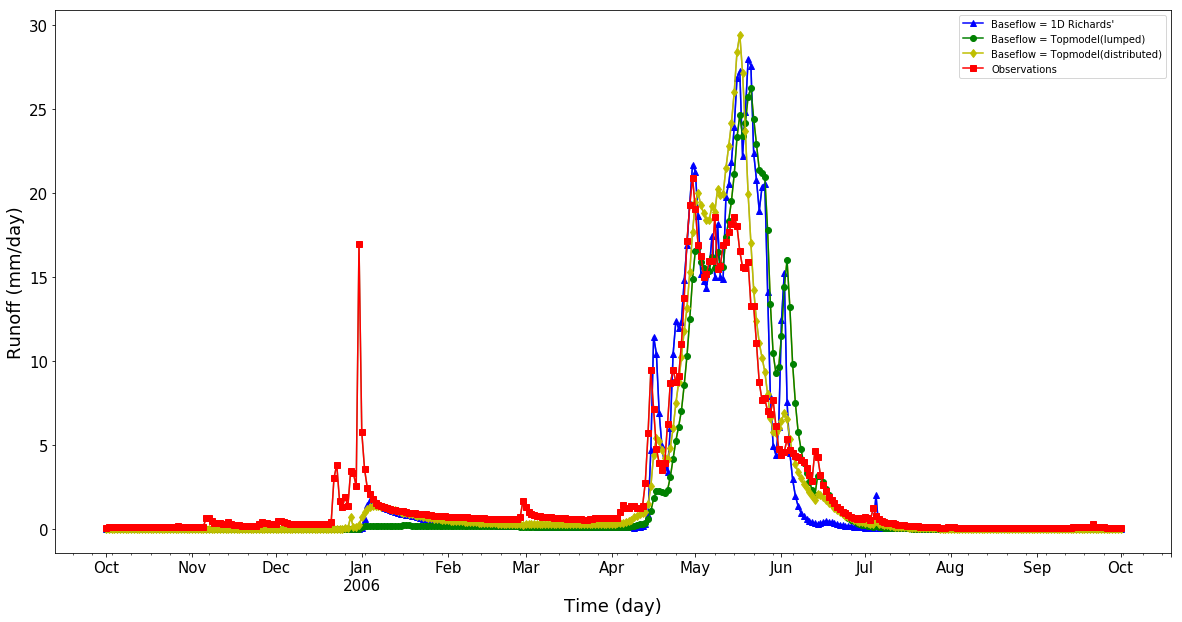

In [92]:
df_filt = df.loc["2005-10-01":"2006-10-01"]
# select label
df_filt.columns = ['Observations']
# resample data by the average daily from hourly 
obs_streamflow_daily1 = df_filt.resample("D").mean()
# set x index accoording to the change of time step
obs_date = obs_streamflow_daily1.index
graph_runoff = pd.concat([Runoff_Combine.loc["2005-10-01":"2006-10-01"], obs_streamflow_daily1], 1)

runoff_graph = graph_runoff.plot()

graph_runoff["Baseflow = 1D Richards'"].plot(color='b', marker='^') 
graph_runoff["Baseflow = Topmodel(lumped)"].plot(color='g', marker='o') 
graph_runoff["Baseflow = Topmodel(distributed)"].plot(color='y', marker='d') 
graph_runoff["Observations"].plot(color='r', marker='s') 

runoff_graph.tick_params(labelsize = 15)

runoff_graph.set_xlabel("Time (day)", fontsize=18)
runoff_graph.set_ylabel("Runoff (mm/day)", fontsize=18)

handles, labels = runoff_graph.get_legend_handles_labels()
runoff_graph.legend(handles[4:8], labels[4:8])

jtplot.figsize(x=20, y=10)

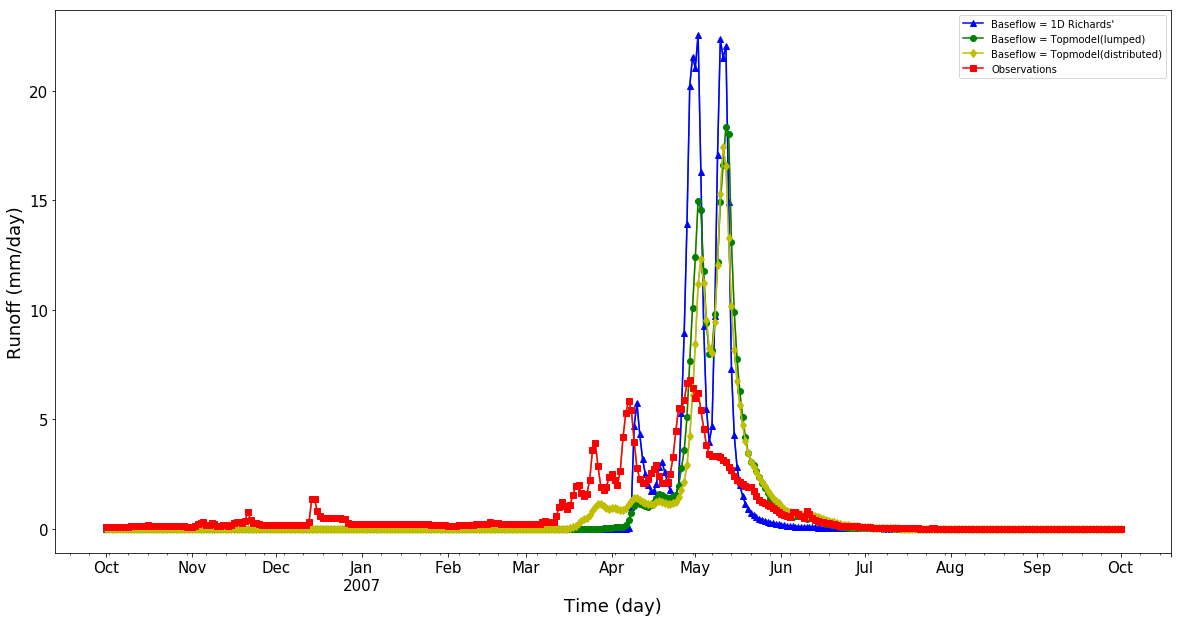

In [93]:
df_filt = df.loc["2006-10-01":"2007-10-01"]
# select label
df_filt.columns = ['Observations']
# resample data by the average daily from hourly 
obs_streamflow_daily1 = df_filt.resample("D").mean()
# set x index accoording to the change of time step
obs_date = obs_streamflow_daily1.index
graph_runoff = pd.concat([Runoff_Combine.loc["2006-10-01":"2007-10-01"], obs_streamflow_daily1], 1)

runoff_graph = graph_runoff.plot()

graph_runoff["Baseflow = 1D Richards'"].plot(color='b', marker='^') 
graph_runoff["Baseflow = Topmodel(lumped)"].plot(color='g', marker='o') 
graph_runoff["Baseflow = Topmodel(distributed)"].plot(color='y', marker='d') 
graph_runoff["Observations"].plot(color='r', marker='s') 

runoff_graph.tick_params(labelsize = 15)

runoff_graph.set_xlabel("Time (day)", fontsize=18)
runoff_graph.set_ylabel("Runoff (mm/day)", fontsize=18)

handles, labels = runoff_graph.get_legend_handles_labels()
runoff_graph.legend(handles[4:8], labels[4:8])

jtplot.figsize(x=20, y=10)

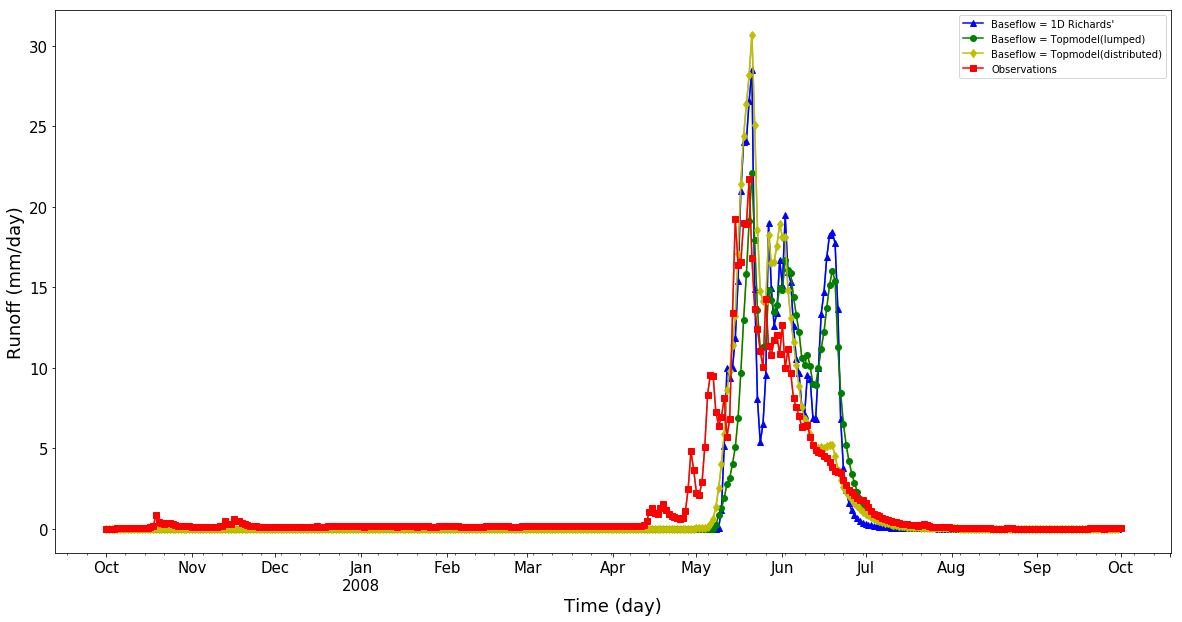

In [94]:
df_filt = df.loc["2007-10-01":"2008-10-01"]
# select label
df_filt.columns = ['Observations']
# resample data by the average daily from hourly 
obs_streamflow_daily1 = df_filt.resample("D").mean()
# set x index accoording to the change of time step
obs_date = obs_streamflow_daily1.index
graph_runoff = pd.concat([Runoff_Combine.loc["2007-10-01":"2008-10-01"], obs_streamflow_daily1], 1)

runoff_graph = graph_runoff.plot()

graph_runoff["Baseflow = 1D Richards'"].plot(color='b', marker='^') 
graph_runoff["Baseflow = Topmodel(lumped)"].plot(color='g', marker='o') 
graph_runoff["Baseflow = Topmodel(distributed)"].plot(color='y', marker='d') 
graph_runoff["Observations"].plot(color='r', marker='s') 

runoff_graph.tick_params(labelsize = 15)

runoff_graph.set_xlabel("Time (day)", fontsize=18)
runoff_graph.set_ylabel("Runoff (mm/day)", fontsize=18)

handles, labels = runoff_graph.get_legend_handles_labels()
runoff_graph.legend(handles[4:8], labels[4:8])

jtplot.figsize(x=20, y=10)

#### 4.7) Validation between the observation and simulation data.

In [78]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from pysumma.Validation import validation

In [79]:
# defind simulation data
richards_simulation = Runoff_Combine["Baseflow = 1D Richards'"]
lumped_simulation = Runoff_Combine['Baseflow = Topmodel(lumped)']
distributed_simulation = Runoff_Combine['Baseflow = Topmodel(distributed)']

In [80]:
observation_data = obs_streamflow_daily

In [81]:
# analyze validtation between 1d richards' runoff simulation and observation data.
validation.analysis(observation_data, richards_simulation)

Mean Absolute Error: 1.010090
Mean Squared Error: 6.857899
Root Mean Squared Error: 2.618759


In [82]:
# analyze validtation between TopModel(lumped) runoff simulation and observation data.
validation.analysis(observation_data, lumped_simulation)

Mean Absolute Error: 0.965819
Mean Squared Error: 5.601555
Root Mean Squared Error: 2.366760


In [83]:
# analyze validtation between TopModel(distributed) runoff simulation and observation data.
validation.analysis(observation_data, distributed_simulation)

Mean Absolute Error: 0.724327
Mean Squared Error: 3.336854
Root Mean Squared Error: 1.826706


## 5. Discussion

As stated in Clark et al., 2015, the following insights can be gained from this analysis:

* The simulation in Figure 8 illustrates the model representation of the lateral flux of liquid water, which determines (in part) the availability of soil water.

* The results in Figure 8 demonstrate strong sensitivities the lateral flow parameterization. The parameterizations are based on power-law transmissivity profiles (both lumped and distributed) that have more drainage of soil water at deeper soil layers; however, the distributed simulations include inflow from upslope, resulting in more plant-available soil water and an increase in transpiration. Taken together, the results in Figure 8 illustrate the strong interdependencies among different modeling decisions, which complicate discriminating among competing process parameterizations.

* Basin-wide runoff is a challenging variable to evaluate: it is the integrated response of the system to externalforcing and, as such, represents an aggregation of many thermodynamic and hydrologic processes.

* Nevertheless, the fingerprint of different parameterizations to simulate lateral fluxes of liquid water are often clearly evident in the basin-wide runoff time series [e.g., Yilmaz et al., 2008; Clark et al., 2009], and there is a large amount of valuable information content in the runoff time series itself [Clark et al., 2011]. 

* In addition, streamflow is often the most accurately measured, spatially integrated component of the hydrological cycle. Here, we compare the model simulations of runoff from a small subset of model options to the observations in the Reynolds Mountain East watershed across multiple water years [Reba et al., 2011]. 

* The subset of model options is selected to illustrate the different types of model behavior, rather than provide an exhaustive analysis of all modeling alternatives.

* Figure 9 illustrates that simulations of basin-wide runoff strongly depends on the model representation of lateral flow. Simulations based on the 1D Richards equation exhibit too many ‘‘spikes’’ in the hydrograph (top plot of Figure 9). 

* In this approach, which common in traditional land-surface models [e.g., Chen and Dudhia,2001], there is no explicit representation of lateral flow – i.e., the source/sink term for lateral subsurface flow in equation (32) is set to zero – and vertical drainage from the bottom of the soil profile is delivered immediately to the stream. 

* This exceedingly spiky behavior occurs because the model does not include the longer residence times present in natural systems. The spatially distributed simulations – i.e., including lateral flow among soil columns – represent the observations reasonably well, without the ephemeral behavior in the 1D Richards solution (bottom plot of Figure 9). 

* In these distributed simulations, multiple hillslope soil columns contribute inflow to the riparian zone, resulting in the persistence of partially saturated soils in the riparian zone and smoother (less spiky) runoff dynamics that are consistent with the observations.

## 6. Post notebook and simulation results back to Hydroshare

In [54]:
from pysumma.hydroshare import hydroshare
hs = hydroshare.hydroshare()

Successfully established a connection with HydroShare


In [55]:
# write meta data such as abstract, title, keywords, rtype
abstract = 'output of SUMMA(Fig9)'
title = 'output of SUMMA(Fig9)'
keywords = ('SUMMA', 'Hydrologic Model')
rtype = 'GenericResource'
files = output_R, output_LT, output_DT
metadata = '[{"creator":{"name":"Youngdon Choi"}}, {"creator":{"name":"Jeffrey Sadler"}}]'
extra_metadata = '{"key-1": "value-1", "key-2": "value-2"}'

In [56]:
# post simulation results of simpleResistance back to HS
resource_id = hs.createHydroShareResource(title=title, content_files=files, keywords=keywords, abstract=abstract, resource_type='genericresource', public=False)

Resource Created Successfully                           
Successfully Added Content Files                      


#### Save this notebook file and add the notebook to the resource of summa output

In [57]:
# add a notebook to the resource of summa output
npath = save_filepath+'/pysumma/sopron_2018_notebooks/pySUMMA_Demo_Example_Fig9_Using_TestCase_from_Hydroshare.ipynb'
# check the resource id on HS that created.
hs.addContentToExistingResource(resource_id, [npath])

Successfully Added Content Files                      


## 7. make this resource public

In [ ]:
# check the resource id 
C_resource_id = 'c3696bdac0954a92be0bf12da9cc96a8'

In [ ]:
# make a resource public
hs.setAccessRules(C_resource_id, public=True)